## Implement The Encoder Decoder Model
#### Third Year - Medical Image Project

Here, Dataset from kaggle of Heart MRI images and corresponding segmentation labels in NIfTI format.
https://www.kaggle.com/code/brsdincer/left-atrial-segmentation-all-process-nii-doc

### Encoder-Decoder
The architecture consists of two main parts:

- Encoder: Processes the input (image) and extracts important features.
- Decoder: Reconstructs the output (segmentation mask) from the encoded features.

### Data Mount


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

data_dir = '/content/drive/My Drive/medical_datasets/'
data_contents = os.listdir(data_dir)

print("Contents of 'medical_datasets' directory:")
print(data_contents)


Contents of 'medical_datasets' directory:
['labelsTr', 'imagesTr', 'imagesTs']


### Library Importing

- NiBabel is a library for reading and writing neuroimaging data files (e.g., NIfTI format). nibabel is imported as nib.
- The os module provides functions to interact with the operating system. It's used here for file path operations.
- resize from skimage.transform: This function is used for resizing images. It's imported from the skimage library.

In [ ]:
import numpy as np
import nibabel as nib
import os
from skimage.transform import resize
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

### Pre Process The Data

#### Why do we have to resize ?
the reason we have to resize the input (image files and label files) is to have consistency. by resizing to a specific image length -> (256,256), we can feed the data into the network during training. It also helps in normalization.The choice of (256, 256) as the target shape is a common practice in medical image analysis

#### Why central size ?
In medical imaging, we often work with 3D volumes, where an image is not just a 2D array of pixels but a stack of multiple 2D slices. The third dimension (usually the z-axis) represents the depth or the slices in the volume. When we load a 3D medical image, it typically has dimensions like (height, width, depth). slice_index = image_data.shape[2] // 2 is a way to calculate the index of the central slice along the z-axis of the 3D medical image volume. And image_data.shape[2] essentially gives the number of slices along the z ( 0,1,*2* ) axis.

In [ ]:
def load_data(image_files, label_files, target_shape=(256, 256)):
    images = []
    labels = []
    for image_file, label_file in zip(image_files, label_files):
        image_data = nib.load(image_file).get_fdata()
        label_data = nib.load(label_file).get_fdata()
        slice_index = image_data.shape[2] // 2

        image_slice = image_data[:, :, slice_index]
        label_slice = label_data[:, :, slice_index]

        image_slice = resize(image_slice, target_shape, anti_aliasing=True)
        label_slice = resize(label_slice, target_shape, anti_aliasing=False, preserve_range=True)

        images.append(image_slice)
        labels.append(label_slice)

    return np.array(images), np.array(labels)

- .get_fdata() : It retrieves the image data from the NIfTI object and returns it as a NumPy array.
- usually the metadata has the orientation and stuff, without fdata() we can't have the pixels of the image.
- anti_aliasing=True means we want to apply anti-aliasing when resizing. Anti-aliasing helps in smoothing the edges, producing a higher quality resized image.
- preserve_range=True ensures that the intensity values of the label remain the same after resizing. This is important for segmentation tasks where each label value has a specific meaning (e.g., background, organ, tumor).

In [ ]:
data_dir = '/content/drive/My Drive/medical_datasets/'
train_dir = os.path.join(data_dir, 'imagesTr')
test_dir = os.path.join(data_dir, 'imagesTs')
label_dir = os.path.join(data_dir, 'labelsTr')

train_image_files = sorted([os.path.join(train_dir, file) for file in os.listdir(train_dir) if file.endswith(".nii")])
test_image_files = sorted([os.path.join(test_dir, file) for file in os.listdir(test_dir) if file.endswith(".nii")])
label_files = sorted([os.path.join(label_dir, file) for file in os.listdir(label_dir) if file.endswith(".nii")])

train_images, train_labels = load_data(train_image_files, label_files)
test_images, test_labels = load_data(test_image_files, label_files)

In [ ]:
print("Train Images Shapes:")
for img in train_images:
    print(img.shape)

print("Train Labels Shapes:")
for lbl in train_labels:
    print(lbl.shape)

print("Test Images Shapes:")
for img in test_images:
    print(img.shape)

print("Test Labels Shapes:")
for lbl in test_labels:
    print(lbl.shape)

Train Images Shapes:
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
Train Labels Shapes:
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
Test Images Shapes:
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
Test Labels Shapes:
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)


#### What is a dataset and dataloader ?
- In pytorch, dataset and dataloaders are two data classes.
- Dataset gives the collection of data samples. The len function gives the length of the dataset and the getitem gives the specific sample from the dataset.
- Dataset: Represents a collection of data samples, providing an interface for accessing individual samples and loading/preprocessing data.
- Dataloaders are responsible for creating batches of data from a dataset object. Provides an iterable over the dataset, returning batches of data during training or testing.
- DataLoader: Creates batches of data from a Dataset, providing features like batching, shuffling, and parallel data loading.


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
            label = self.transform(label)

        return image, label

transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = CustomDataset(train_images, train_labels, transform=transform)
test_dataset = CustomDataset(test_images, test_labels, transform=transform)

batch_size = 4 # specifies the number of samples in each batch, so as we keep increasing, the longer it takes.

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

for images, labels in train_loader:
    pass

for images, labels in test_loader:
    pass


### Encoder
the encoder is responsible for extracting features from the input data.


- here, nn is the neural network module which we call for the functions
- nn.Module is the base class for all neural network modules in PyTorch.

#### ReLU
we know that the activation functions at the end of the hidden layers in neural networks, give nonlinearity to the model. ReLU apparenty gives the input itself for any >0 input, and zero for any <0 input

`([-1, 0, 1, 2, -3, 4]) -> Output: tensor([0., 0., 1., 2., 0., 4.])`

#### Max Pooling
downsampling in the CNN, it is used to reduce the spatial dimensions of feature maps. it reduces the image, while preserving the features.


```
Max Pooling operates over each n × n window of the input feature map.
For each window, it takes the maximum value and discards the rest.
```



the parameters here, 1 - input channel, 16 - output channel

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool(x)
        return x

### Decoder

In [ ]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.relu1 = nn.ReLU()
        self.deconv2 = nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.deconv1(x)
        x = self.relu1(x)
        x = self.deconv2(x)
        x = self.sigmoid(x)
        return x


### Full Model

In [ ]:
class EncoderDecoder(nn.Module):
    def __init__(self):
        super(EncoderDecoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Train Model

In [ ]:
model = EncoderDecoder()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(torch.float32)
        labels = labels.to(torch.float32)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

Epoch 1/15, Loss: 8.777888298034668
Epoch 2/15, Loss: 2.1197671055793763
Epoch 3/15, Loss: 0.9167158007621765
Epoch 4/15, Loss: 0.9100257277488708
Epoch 5/15, Loss: 0.9205760717391968
Epoch 6/15, Loss: 0.9210794329643249
Epoch 7/15, Loss: 0.9192202687263489
Epoch 8/15, Loss: 0.9120922803878784
Epoch 9/15, Loss: 0.9048883199691773
Epoch 10/15, Loss: 0.8981493473052978
Epoch 11/15, Loss: 0.8916876912117004
Epoch 12/15, Loss: 0.8851850509643555
Epoch 13/15, Loss: 0.8780885219573975
Epoch 14/15, Loss: 0.8702748537063598
Epoch 15/15, Loss: 0.8595119714736938


### Test Model

In [ ]:
model.eval()
test_loss = 0.0
num_batches = len(test_loader)

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(torch.float32)
        labels = labels.to(torch.float32)

        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

average_test_loss = test_loss / num_batches
print(f"Average Test Loss: {average_test_loss}")


Average Test Loss: 0.681135098139445


### Plot Images

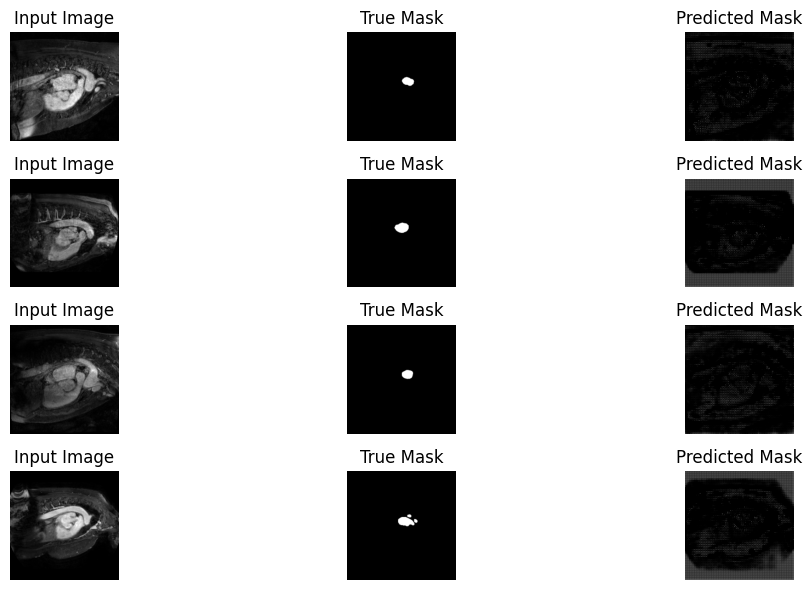

In [ ]:
import matplotlib.pyplot as plt

images, labels = next(iter(test_loader))
images = images.to(torch.float32)
labels = labels.to(torch.float32)
outputs = model(images)
predicted_masks = outputs.cpu().detach().numpy()

plt.figure(figsize=(12, 6))
for i in range(4):
    plt.subplot(4, 3, i*3 + 1)
    plt.imshow(images[i, 0], cmap='gray')
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(4, 3, i*3 + 2)
    plt.imshow(labels[i, 0], cmap='gray')
    plt.title("True Mask")
    plt.axis("off")

    plt.subplot(4, 3, i*3 + 3)
    plt.imshow(predicted_masks[i, 0], cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")

plt.tight_layout()
plt.show()
